# Dataset Distillation for Cat and Dog Image Classification - Further Investigation of Grid Clustering

## from "Ministry of Learning From Data Engineers"


#### Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

2024-07-11 13:35:30.889147: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 13:35:30.889261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 13:35:31.047193: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Loading

In [2]:
# Define data directories for cats and dogs
cat_dir = "/kaggle/input/petimagescat-and-dog/PetImages/Cat"
dog_dir = "/kaggle/input/petimagescat-and-dog/PetImages/Dog"

# Define image size
img_size = 150

import time

def load_data(data_dir, label, count=7500, img_size=150):
    images = []
    labels = []

    i = 0
    
    for img_file in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img_file)
        try:
            # Read and resize image
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))
            # Normalize pixel values
            img = img.astype(np.float32) / 255.0
            images.append(img)
            labels.append(label)
            i += 1
            if i % 1000 == 0:
                print(f"Loaded {i} images")
            
            # Check runtime
            if i >= count:
                break
             
        except Exception as e:
            continue
            
    return np.array(images), np.array(labels)


In [3]:
# Load and preprocess data for cats and dogs
print("Loading cat data...")
X_cat, y_cat = load_data(cat_dir, label=0)  # Cat label: 0
print("\nLoading dog data...")
X_dog, y_dog = load_data(dog_dir, label=1)  # Dog label: 1

# Concatenate cat and dog data
X = np.concatenate((X_cat, X_dog), axis=0)
y = np.concatenate((y_cat, y_dog), axis=0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Print shapes for verification
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Loading cat data...


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


Loaded 1000 images


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


Loaded 2000 images
Loaded 3000 images
Loaded 4000 images
Loaded 5000 images


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


Loaded 6000 images


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


Loaded 7000 images

Loading dog data...
Loaded 1000 images


Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


Loaded 2000 images


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


Loaded 3000 images


Loaded 4000 images
Loaded 5000 images
Loaded 6000 images


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Loaded 7000 images


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


X_train shape: (13500, 150, 150, 3)
y_train shape: (13500,)


## Base Model

In [4]:
class CNNModel:
    def __init__(self, img_size):
        self.img_size = img_size
        self.model = self._build_model()
    
    def _build_model(self):
        model = Sequential([
            Conv2D(64, (3, 3), padding='same', input_shape=(self.img_size, self.img_size, 3)),
            BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            MaxPooling2D((2, 2)),

            Conv2D(128, (3, 3), padding='same'),
            BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            MaxPooling2D((2, 2)),

            Conv2D(256, (3, 3), padding='same'),
            BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            MaxPooling2D((2, 2)),

            Conv2D(256, (3, 3), padding='same'),
            BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), padding='same'),
            BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), padding='same'),
            BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            MaxPooling2D((2, 2)),

            Flatten(),

            Dense(512),
            BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            Dropout(0.5),

            Dense(1, activation='sigmoid')  # Binary classification output
        ])
        return model

    
    def compile(self):
        self.model.compile(optimizer=Adam(),
                           loss='binary_crossentropy',
                           metrics=['accuracy'])
    
    def summary(self):
        self.model.summary()
    
    def train(self, X_train, y_train, X_val, y_val, batch_size=32, epochs=20):
        self.history = self.model.fit(X_train, y_train,
                                      batch_size=batch_size,
                                      epochs=epochs,
                                      validation_data=(X_val, y_val))
    
    def evaluate(self, X_test, y_test):
        test_loss, test_acc = self.model.evaluate(X_test, y_test)
        print('Test accuracy:', test_acc)
        return test_loss, test_acc

In [5]:
cnn_base = CNNModel(img_size=150)
cnn_base.compile()
cnn_base.summary()
plot_model(cnn_base.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
cnn_base.train(X_train, y_train, X_test, y_test, batch_size=32, epochs=20)

cnn_base_loss, cnn_base_acc = cnn_base.evaluate(X_test, y_test)

# Plot training and validation accuracy
plt.plot(cnn_base.history.history['accuracy'])
plt.plot(cnn_base.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(cnn_base.history.history['loss'])
plt.plot(cnn_base.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save model
cnn_base.model.save('cnn_base.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 9, 9, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 1,467,457 (5.60 MB)

 Trainable params: 1,464,641 (5.59 MB)

 Non-trainable params: 2,816 (11.00 KB)

Epoch 1/20
  2/422 ━━━━━━━━━━━━━━━━━━━━ 38s 91ms/step - accuracy: 0.6641 - loss: 0.6993   

I0000 00:00:1720705070.117779     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


422/422 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - accuracy: 0.6291 - loss: 0.7186 - val_accuracy: 0.6880 - val_loss: 0.5828
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 29s 69ms/step - accuracy: 0.7913 - loss: 0.4549 - val_accuracy: 0.8193 - val_loss: 0.4239
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.8591 - loss: 0.3287 - val_accuracy: 0.8047 - val_loss: 0.4719
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.8959 - loss: 0.2481 - val_accuracy: 0.8633 - val_loss: 0.3266
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9176 - loss: 0.1962 - val_accuracy: 0.7553 - val_loss: 0.5248
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9379 - loss: 0.1572 - val_accuracy: 0.8980 - val_loss: 0.2351
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9513 - loss: 0.1238 - val_accuracy: 0.7887 - val_loss: 0.6881
Epoch 8/20
360/422 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9710 - loss: 0.0798

KeyboardInterrupt: 

## Clustering Distillation

In [7]:
class ImageClusterSampler:
    def __init__(self, X, y, n_clusters=2):
        self.X = X
        self.y = y
        self.n_clusters = n_clusters
        self.cluster_labels = None
        self.X_pca = None
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.pca = PCA(n_components=2, random_state=42)
    
    def cluster_images(self):
        self.kmeans.fit(self.X.reshape(self.X.shape[0], -1))
        self.cluster_labels = self.kmeans.labels_
        self.X_pca = self.pca.fit_transform(self.X.reshape(self.X.shape[0], -1))

    def plot_clusters(self):
        plt.figure(figsize=(10, 6))
        for i in range(self.n_clusters):
            cluster_data = self.X_pca[self.cluster_labels == i]
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}')
        plt.title('Clustering of Cats and Dogs')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.legend()
        plt.show()

    def select_diverse_samples(self, cluster_indices, n_samples):


        if len(cluster_indices) <= n_samples:
            return cluster_indices
        
        selected_indices = []
        grid_size = int(np.ceil(np.sqrt(n_samples)))
        x_min, x_max = np.min(self.X_pca[:, 0]), np.max(self.X_pca[:, 0])
        y_min, y_max = np.min(self.X_pca[:, 1]), np.max(self.X_pca[:, 1])
        
        x_grid = np.linspace(x_min, x_max, grid_size + 1)
        y_grid = np.linspace(y_min, y_max, grid_size + 1)
        
        # plot also all the grids for each iteration on the same graph
        for i in range(grid_size):
            for j in range(grid_size):
                x_start, x_end = x_grid[i], x_grid[i + 1]
                y_start, y_end = y_grid[j], y_grid[j + 1]


                
                grid_indices = [
                    idx for idx in cluster_indices 
                    if x_start <= self.X_pca[idx, 0] < x_end and y_start <= self.X_pca[idx, 1] < y_end
                ]
                
                if grid_indices:
                    selected_indices.append(np.random.choice(grid_indices))

                
        
        while len(selected_indices) < n_samples:
            selected_indices.append(np.random.choice(cluster_indices))
        
        return selected_indices[:n_samples]

    def get_selected_samples(self, n_samples):
        selected_samples = []
        for label in range(2):
            label_indices = np.where(self.y == label)[0]
            label_cluster_labels = self.cluster_labels[label_indices]
            unique_clusters = np.unique(label_cluster_labels)
            
            for cluster_id in unique_clusters:
                cluster_indices = label_indices[label_cluster_labels == cluster_id]
                selected_indices = self.select_diverse_samples(cluster_indices, n_samples)
                selected_samples.extend(selected_indices)
        return selected_samples
    
    def plot_selected_samples_on_clusters(self, selected_samples):
        plt.figure(figsize=(10, 6))
        for i in range(self.n_clusters):
            cluster_data = self.X_pca[self.cluster_labels == i]
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}', alpha=0.5)
        
        selected_data = self.X_pca[selected_samples]
        plt.scatter(selected_data[:, 0], selected_data[:, 1], color='red', label='Selected Samples', edgecolor='k')
        
        plt.title('Clustering of Cats and Dogs with Selected Samples')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.legend()
        plt.show()




### 10%

In [ ]:
# Create image cluster sampler
sampler = ImageClusterSampler(X, y, n_clusters=2)
sampler.cluster_images()
sampler.plot_clusters()
selected_samples_1350 = sampler.get_selected_samples(1350)
sampler.plot_selected_samples_on_clusters(selected_samples_1350)

In [ ]:
X_selected = X[selected_samples_1350]
y_selected = y[selected_samples_1350]

cnn_base_clustering_2 = CNNModel(img_size=150)
cnn_base_clustering_2.compile()
cnn_base_clustering_2.train(X_selected, y_selected, X_test, y_test, batch_size=32, epochs=20)
cnn_base_clustering_2_test_loss, cnn_base_clustering_2_test_acc = cnn_base_clustering_2.evaluate(X_test, y_test)

# Save model
cnn_base_clustering_2.model.save('cnn_base_clustering.h5')

# Plot training and validation accuracy
plt.plot(cnn_base_clustering_2.history.history['accuracy'])
plt.plot(cnn_base_clustering_2.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print('Test accuracy:', cnn_base_clustering_2_test_acc)
print('Test loss:', cnn_base_clustering_2_test_loss)

## 5%

In [ ]:
# do the 670 samples
selected_samples_670 = sampler.get_selected_samples(670)
sampler.plot_selected_samples_on_clusters(selected_samples_670)

X_selected = X[selected_samples_670]
y_selected = y[selected_samples_670]

cnn_base_clustering_3 = CNNModel(img_size=150)
cnn_base_clustering_3.compile()

cnn_base_clustering_3.train(X_selected, y_selected, X_test, y_test, batch_size=32, epochs=20)
cnn_base_clustering_3_test_loss, cnn_base_clustering_3_test_acc = cnn_base_clustering_3.evaluate(X_test, y_test)

# Save model
cnn_base_clustering_3.model.save('cnn_base_clustering_3.h5')

# Plot training and validation accuracy
plt.plot(cnn_base_clustering_3.history.history['accuracy'])
plt.plot(cnn_base_clustering_3.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Redefine the Cluster Method

In [8]:
class GridImageClusterSampler(ImageClusterSampler):
    def plot_clusters_with_grids(self, n_samples):
        plt.figure(figsize=(10, 6))
        for i in range(self.n_clusters):
            cluster_data = self.X_pca[self.cluster_labels == i]
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}', alpha=0.5)
        
        grid_size = int(np.ceil(np.sqrt(n_samples)))
        x_min, x_max = np.min(self.X_pca[:, 0]), np.max(self.X_pca[:, 0])
        y_min, y_max = np.min(self.X_pca[:, 1]), np.max(self.X_pca[:, 1])
        
        x_grid = np.linspace(x_min, x_max, grid_size + 1)
        y_grid = np.linspace(y_min, y_max, grid_size + 1)
        
        for x in x_grid:
            plt.axvline(x=x, color='k', linestyle='--', alpha=0.5)
        for y in y_grid:
            plt.axhline(y=y, color='k', linestyle='--', alpha=0.5)
        
        plt.title('Clustering of Cats and Dogs with Grids')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.legend()
        plt.show()
    
    def get_grid_sampled_indices(self, cluster_indices, n_samples):
        if len(cluster_indices) <= n_samples:
            return cluster_indices
        
        grid_size = int(np.ceil(np.sqrt(n_samples)))
        x_min, x_max = np.min(self.X_pca[:, 0]), np.max(self.X_pca[:, 0])
        y_min, y_max = np.min(self.X_pca[:, 1]), np.max(self.X_pca[:, 1])
        
        x_grid = np.linspace(x_min, x_max, grid_size + 1)
        y_grid = np.linspace(y_min, y_max, grid_size + 1)
        
        sampled_indices = []
        for i in range(grid_size):
            for j in range(grid_size):
                x_start, x_end = x_grid[i], x_grid[i + 1]
                y_start, y_end = y_grid[j], y_grid[j + 1]
                
                grid_indices = [
                    idx for idx in cluster_indices 
                    if x_start <= self.X_pca[idx, 0] < x_end and y_start <= self.X_pca[idx, 1] < y_end
                ]
                
                if grid_indices:
                    sampled_indices.append(np.random.choice(grid_indices))

        while len(sampled_indices) < n_samples:
            sampled_indices.append(np.random.choice(cluster_indices))
        
        return sampled_indices[:n_samples]

    def get_selected_samples(self, n_samples):
        selected_samples = []
        for label in range(2):
            label_indices = np.where(self.y == label)[0]
            label_cluster_labels = self.cluster_labels[label_indices]
            unique_clusters = np.unique(label_cluster_labels)
            
            for cluster_id in unique_clusters:
                cluster_indices = label_indices[label_cluster_labels == cluster_id]
                selected_indices = self.get_grid_sampled_indices(cluster_indices, n_samples)
                selected_samples.extend(selected_indices)
        return selected_samples


## paralelograms

In [9]:
class ParallelogramImageClusterSampler:
    def __init__(self, X, y, n_clusters=2):
        self.X = X
        self.y = y
        self.n_clusters = n_clusters
        self.cluster_labels = None
        self.X_pca = None
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.pca = PCA(n_components=2, random_state=42)
    
    def cluster_images(self):
        self.kmeans.fit(self.X.reshape(self.X.shape[0], -1))
        self.cluster_labels = self.kmeans.labels_
        self.X_pca = self.pca.fit_transform(self.X.reshape(self.X.shape[0], -1))

    def plot_clusters_with_parallelograms(self, angle=30, grid_size=10):
        plt.figure(figsize=(10, 6))
        for i in range(self.n_clusters):
            cluster_data = self.X_pca[self.cluster_labels == i]
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}', alpha=0.5)
        
        x_min, x_max = np.min(self.X_pca[:, 0]), np.max(self.X_pca[:, 0])
        y_min, y_max = np.min(self.X_pca[:, 1]), np.max(self.X_pca[:, 1])
        
        x_length = (x_max - x_min) / grid_size
        dx = x_length * np.cos(np.radians(angle))
        dy = x_length * np.sin(np.radians(angle))
        y_length = dy

        for i in range(grid_size):
            for j in range(grid_size):
                x_start = x_min + i * x_length
                y_start = y_min + j * y_length

                parallelogram = [
                    (x_start, y_start),
                    (x_start + x_length, y_start),
                    (x_start + x_length + dx, y_start + dy),
                    (x_start + dx, y_start + dy)
                ]
                
                parallelogram_x, parallelogram_y = zip(*parallelogram)
                plt.plot(parallelogram_x + (parallelogram_x[0],), parallelogram_y + (parallelogram_y[0],), 'k--', alpha=0.5)
        
        plt.title('Clustering with Parallelogram Grids')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.legend()
        plt.show()
    
    def get_parallelogram_sampled_indices(self, cluster_indices, n_samples, angle=30, grid_size=10):
        if len(cluster_indices) <= n_samples:
            return cluster_indices
        
        x_min, x_max = np.min(self.X_pca[:, 0]), np.max(self.X_pca[:, 0])
        y_min, y_max = np.min(self.X_pca[:, 1]), np.max(self.X_pca[:, 1])
        
        x_length = (x_max - x_min) / grid_size
        dx = x_length * np.cos(np.radians(angle))
        dy = x_length * np.sin(np.radians(angle))
        y_length = dy
        
        sampled_indices = []
        
        for i in range(grid_size):
            for j in range(grid_size):
                x_start = x_min + i * x_length
                y_start = y_min + j * y_length

                parallelogram_indices = [
                    idx for idx in cluster_indices 
                    if (self.X_pca[idx, 0] >= x_start and self.X_pca[idx, 0] < x_start + x_length + dx and
                        self.X_pca[idx, 1] >= y_start and self.X_pca[idx, 1] < y_start + y_length and
                        (self.X_pca[idx, 1] - y_start) < dy / dx * (self.X_pca[idx, 0] - x_start + x_length))
                ]
                
                if parallelogram_indices:
                    sampled_indices.append(np.random.choice(parallelogram_indices))

        while len(sampled_indices) < n_samples:
            sampled_indices.append(np.random.choice(cluster_indices))
        
        return sampled_indices[:n_samples]

    def get_selected_samples(self, n_samples):
        selected_samples = []
        for label in range(2):
            label_indices = np.where(self.y == label)[0]
            label_cluster_labels = self.cluster_labels[label_indices]
            unique_clusters = np.unique(label_cluster_labels)
            
            for cluster_id in unique_clusters:
                cluster_indices = label_indices[label_cluster_labels == cluster_id]
                selected_indices = self.get_parallelogram_sampled_indices(cluster_indices, n_samples)
                selected_samples.extend(selected_indices)
        return selected_samples

    def plot_selected_samples_on_clusters(self, selected_samples):
        plt.figure(figsize=(10, 6))
        for i in range(self.n_clusters):
            cluster_data = self.X_pca[self.cluster_labels == i]
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}', alpha=0.5)
        
        selected_data = self.X_pca[selected_samples]
        plt.scatter(selected_data[:, 0], selected_data[:, 1], color='red', label='Selected Samples', edgecolor='k')
        
        plt.title('Clustering with Selected Samples')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.legend()
        plt.show()


## triangles

In [10]:

class TriangularImageClusterSampler:
    def __init__(self, X, y, n_clusters=2):
        self.X = X
        self.y = y
        self.n_clusters = n_clusters
        self.cluster_labels = None
        self.X_pca = None
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.pca = PCA(n_components=2, random_state=42)
    
    def cluster_images(self):
        self.kmeans.fit(self.X.reshape(self.X.shape[0], -1))
        self.cluster_labels = self.kmeans.labels_
        self.X_pca = self.pca.fit_transform(self.X.reshape(self.X.shape[0], -1))

    def plot_clusters_with_triangles(self, grid_size=10):
        plt.figure(figsize=(10, 6))
        for i in range(self.n_clusters):
            cluster_data = self.X_pca[self.cluster_labels == i]
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}', alpha=0.5)
        
        x_min, x_max = np.min(self.X_pca[:, 0]), np.max(self.X_pca[:, 0])
        y_min, y_max = np.min(self.X_pca[:, 1]), np.max(self.X_pca[:, 1])
        
        side_length = (x_max - x_min) / grid_size
        height = np.sqrt(3) / 2 * side_length
        
        for i in range(-1, grid_size + 1):
            for j in range(-1, grid_size + 1):
                x_start = x_min + i * side_length
                y_start = y_min + j * height

                if (i + j) % 2 == 0:
                    triangle = [
                        (x_start, y_start),
                        (x_start + side_length / 2, y_start + height),
                        (x_start - side_length / 2, y_start + height)
                    ]
                else:
                    triangle = [
                        (x_start, y_start),
                        (x_start + side_length, y_start),
                        (x_start + side_length / 2, y_start + height)
                    ]

                triangle_x, triangle_y = zip(*triangle)
                plt.plot(triangle_x + (triangle_x[0],), triangle_y + (triangle_y[0],), 'k--', alpha=0.5)
        
        plt.title('Clustering with Triangular Grids')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.legend()
        plt.show()
    
    def get_triangle_sampled_indices(self, cluster_indices, n_samples, grid_size=10):
        if len(cluster_indices) <= n_samples:
            return cluster_indices
        
        x_min, x_max = np.min(self.X_pca[:, 0]), np.max(self.X_pca[:, 0])
        y_min, y_max = np.min(self.X_pca[:, 1]), np.max(self.X_pca[:, 1])
        
        side_length = (x_max - x_min) / grid_size
        height = np.sqrt(3) / 2 * side_length
        
        sampled_indices = []
        
        for i in range(-1, grid_size + 1):
            for j in range(-1, grid_size + 1):
                x_start = x_min + i * side_length
                y_start = y_min + j * height

                if (i + j) % 2 == 0:
                    triangle_indices = [
                        idx for idx in cluster_indices 
                        if self.point_in_triangle(self.X_pca[idx], 
                                                  (x_start, y_start), 
                                                  (x_start + side_length / 2, y_start + height), 
                                                  (x_start - side_length / 2, y_start + height))
                    ]
                else:
                    triangle_indices = [
                        idx for idx in cluster_indices 
                        if self.point_in_triangle(self.X_pca[idx], 
                                                  (x_start, y_start), 
                                                  (x_start + side_length, y_start), 
                                                  (x_start + side_length / 2, y_start + height))
                    ]

                if triangle_indices:
                    sampled_indices.append(np.random.choice(triangle_indices))

        while len(sampled_indices) < n_samples:
            sampled_indices.append(np.random.choice(cluster_indices))
        
        return sampled_indices[:n_samples]
    
    def point_in_triangle(self, point, v1, v2, v3):
        def sign(p1, p2, p3):
            return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
        
        b1 = sign(point, v1, v2) < 0.0
        b2 = sign(point, v2, v3) < 0.0
        b3 = sign(point, v3, v1) < 0.0
        
        return ((b1 == b2) & (b2 == b3))

    def get_selected_samples(self, n_samples):
        selected_samples = []
        for label in range(2):
            label_indices = np.where(self.y == label)[0]
            label_cluster_labels = self.cluster_labels[label_indices]
            unique_clusters = np.unique(label_cluster_labels)
            
            for cluster_id in unique_clusters:
                cluster_indices = label_indices[label_cluster_labels == cluster_id]
                selected_indices = self.get_triangle_sampled_indices(cluster_indices, n_samples)
                selected_samples.extend(selected_indices)
        return selected_samples

    def plot_selected_samples_on_clusters(self, selected_samples):
        plt.figure(figsize=(10, 6))
        for i in range(self.n_clusters):
            cluster_data = self.X_pca[self.cluster_labels == i]
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}', alpha=0.5)
        
        selected_data = self.X_pca[selected_samples]
        plt.scatter(selected_data[:, 0], selected_data[:, 1], color='red', label='Selected Samples', edgecolor='k')
        
        plt.title('Clustering with Selected Samples')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.legend()
        plt.show()



## Brick-like

In [11]:
class BrickImageClusterSampler(ImageClusterSampler):
    def plot_clusters_with_bricks(self, n_samples):
        plt.figure(figsize=(10, 6))
        for i in range(self.n_clusters):
            cluster_data = self.X_pca[self.cluster_labels == i]
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}', alpha=0.5)
        
        grid_size = int(np.ceil(np.sqrt(n_samples)))
        x_min, x_max = np.min(self.X_pca[:, 0]), np.max(self.X_pca[:, 0])
        y_min, y_max = np.min(self.X_pca[:, 1]), np.max(self.X_pca[:, 1])
        
        x_grid = np.linspace(x_min, x_max, grid_size + 1)
        y_grid = np.linspace(y_min, y_max, grid_size + 1)
        
        # Define the parallelogram shape by skewing the grid
        skew_factor = (x_max - x_min) / (grid_size * 2)  # Adjust skew factor as needed
        
        for i in range(grid_size):
            for j in range(grid_size):
                x_start, x_end = x_grid[i] + j * skew_factor, x_grid[i + 1] + j * skew_factor
                y_start, y_end = y_grid[j], y_grid[j + 1]
                
                plt.plot([x_start, x_end], [y_start, y_start], 'k--', alpha=0.5)
                plt.plot([x_start, x_end], [y_end, y_end], 'k--', alpha=0.5)
                plt.plot([x_start, x_start], [y_start, y_end], 'k--', alpha=0.5)
                plt.plot([x_end, x_end], [y_start, y_end], 'k--', alpha=0.5)
        
        plt.title('Clustering of Cats and Dogs with Brick Grids')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.legend()
        plt.show()
    
    def get_brick_sampled_indices(self, cluster_indices, n_samples):
        if len(cluster_indices) <= n_samples:
            return cluster_indices
        
        grid_size = int(np.ceil(np.sqrt(n_samples)))
        x_min, x_max = np.min(self.X_pca[:, 0]), np.max(self.X_pca[:, 0])
        y_min, y_max = np.min(self.X_pca[:, 1]), np.max(self.X_pca[:, 1])
        
        x_grid = np.linspace(x_min, x_max, grid_size + 1)
        y_grid = np.linspace(y_min, y_max, grid_size + 1)
        
        sampled_indices = []
        skew_factor = (x_max - x_min) / (grid_size * 2)  # Adjust skew factor as needed
        
        for i in range(grid_size):
            for j in range(grid_size):
                x_start, x_end = x_grid[i] + j * skew_factor, x_grid[i + 1] + j * skew_factor
                y_start, y_end = y_grid[j], y_grid[j + 1]
                
                grid_indices = [
                    idx for idx in cluster_indices 
                    if x_start <= self.X_pca[idx, 0] < x_end and y_start <= self.X_pca[idx, 1] < y_end
                ]
                
                if grid_indices:
                    sampled_indices.append(np.random.choice(grid_indices))

        while len(sampled_indices) < n_samples:
            sampled_indices.append(np.random.choice(cluster_indices))
        
        return sampled_indices[:n_samples]

    def get_selected_samples(self, n_samples):
        selected_samples = []
        for label in range(2):
            label_indices = np.where(self.y == label)[0]
            label_cluster_labels = self.cluster_labels[label_indices]
            unique_clusters = np.unique(label_cluster_labels)
            
            for cluster_id in unique_clusters:
                cluster_indices = label_indices[label_cluster_labels == cluster_id]
                selected_indices = self.get_parallelogram_sampled_indices(cluster_indices, n_samples)
                selected_samples.extend(selected_indices)
        return selected_samples

## Testing

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


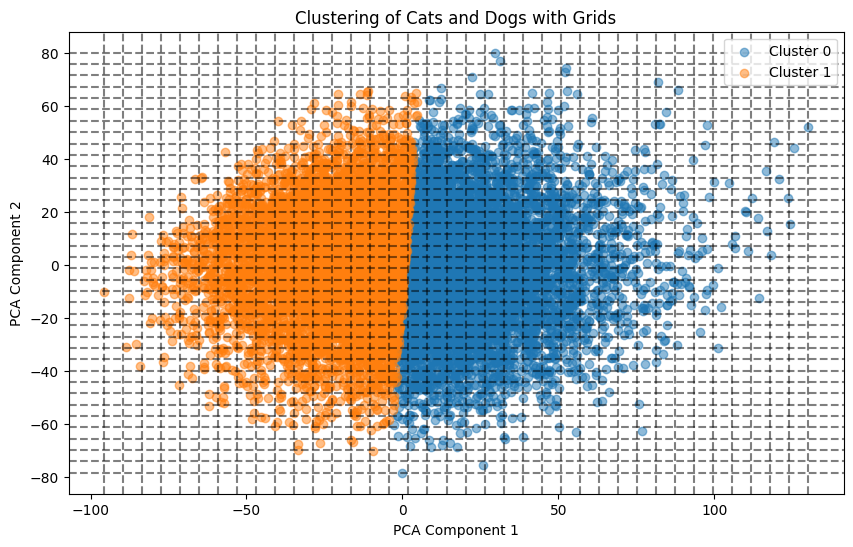

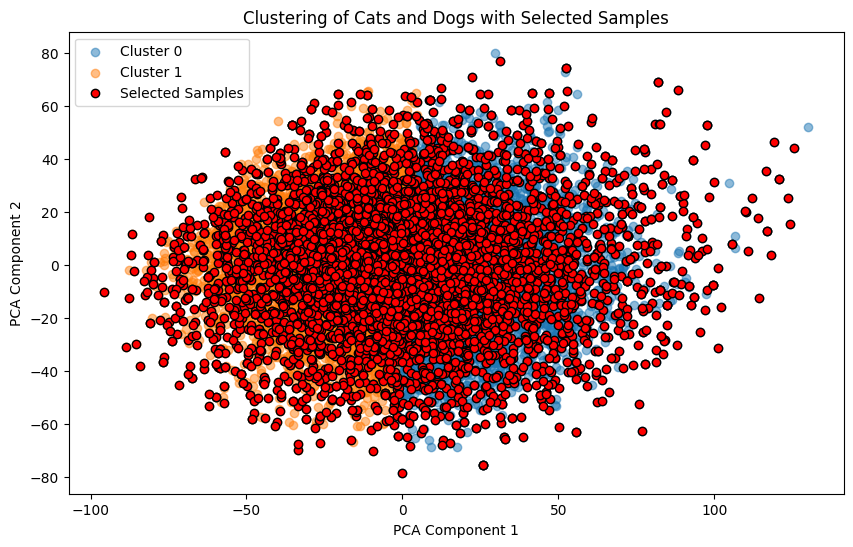

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 162ms/step - accuracy: 0.5593 - loss: 0.7997 - val_accuracy: 0.5000 - val_loss: 0.8206
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.7084 - loss: 0.5820 - val_accuracy: 0.5047 - val_loss: 1.0997
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.7632 - loss: 0.4919 - val_accuracy: 0.5620 - val_loss: 0.8047
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.8058 - loss: 0.4127 - val_accuracy: 0.6807 - val_loss: 0.6501
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.8603 - loss: 0.3109 - val_accuracy: 0.7060 - val_loss: 0.6123
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.8900 - loss: 0.2540 - val_accuracy: 0.8253 - val_loss: 0.4069
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.9416 - loss: 0.1655 - val_accuracy: 0.5980 - val_loss: 1.2918
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.9401 - loss: 0.1557 -

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


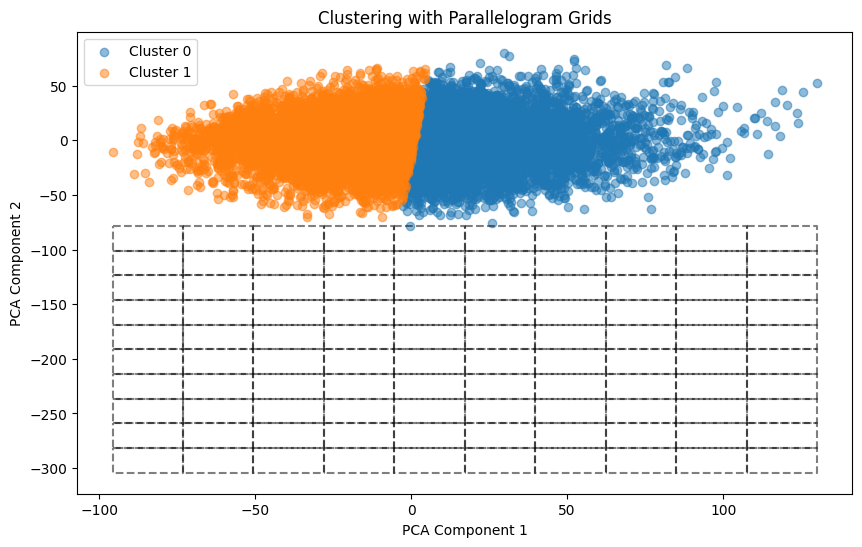

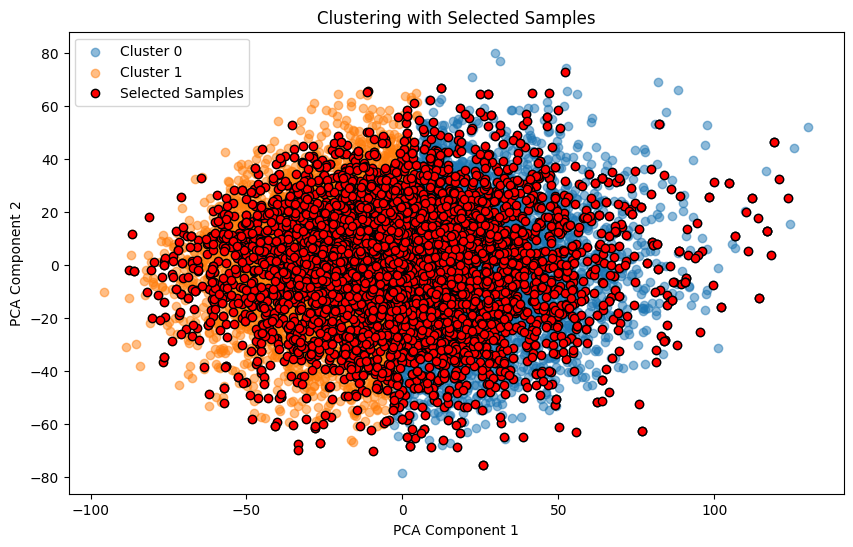

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 118ms/step - accuracy: 0.5838 - loss: 0.7687 - val_accuracy: 0.5013 - val_loss: 0.7182
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.7076 - loss: 0.5861 - val_accuracy: 0.5713 - val_loss: 0.6653
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.7838 - loss: 0.4627 - val_accuracy: 0.7447 - val_loss: 0.4983
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.8319 - loss: 0.3744 - val_accuracy: 0.7833 - val_loss: 0.4575
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.8879 - loss: 0.2729 - val_accuracy: 0.7040 - val_loss: 0.7709
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.9124 - loss: 0.2111 - val_accuracy: 0.8267 - val_loss: 0.4558
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.9309 - loss: 0.1714 - val_accuracy: 0.7513 - val_loss: 0.7694
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.9563 - loss: 0.1152 -

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Create image cluster sampler with all the grid types and train the model and compare the results, cluster images only 1 time
sampler = GridImageClusterSampler(X, y, n_clusters=2)
sampler.cluster_images()
sampler.plot_clusters_with_grids(1350)
selected_samples_1350 = sampler.get_selected_samples(1350)
sampler.plot_selected_samples_on_clusters(selected_samples_1350)

X_selected = X[selected_samples_1350]
y_selected = y[selected_samples_1350]

cnn_base_clustering_4 = CNNModel(img_size=150)
cnn_base_clustering_4.compile()
cnn_base_clustering_4.train(X_selected, y_selected, X_test, y_test, batch_size=32, epochs=20)
cnn_base_clustering_4_test_loss, cnn_base_clustering_4_test_acc = cnn_base_clustering_4.evaluate(X_test, y_test)

print("GridImageClusterSampler")
print('Test accuracy:', cnn_base_clustering_4_test_acc)
print('Test loss:', cnn_base_clustering_4_test_loss)


sampler = ParallelogramImageClusterSampler(X, y, n_clusters=2)
sampler.cluster_images()
sampler.plot_clusters_with_parallelograms(1350)
selected_samples_1350 = sampler.get_selected_samples(1350)
sampler.plot_selected_samples_on_clusters(selected_samples_1350)

X_selected = X[selected_samples_1350]
y_selected = y[selected_samples_1350]

cnn_base_clustering_5 = CNNModel(img_size=150)
cnn_base_clustering_5.compile()
cnn_base_clustering_5.train(X_selected, y_selected, X_test, y_test, batch_size=32, epochs=20)
cnn_base_clustering_5_test_loss, cnn_base_clustering_5_test_acc = cnn_base_clustering_5.evaluate(X_test, y_test)

print("ParallelogramImageClusterSampler")
print('Test accuracy:', cnn_base_clustering_5_test_acc)
print('Test loss:', cnn_base_clustering_5_test_loss)







## Small Dataset Experiments

In [ ]:


# create a dataset with 1000 points, 2 features and 2 clusters and test the clustering algorithms (grid, parallelogram, triangular, brick)
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.title('Generated Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)
cluster_labels = kmeans.labels_

plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis')
plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

sampler = GridImageClusterSampler(X, y, n_clusters=2)
sample_indices = sampler.get_selected_samples(100)
selected_data = X[sample_indices]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.scatter(selected_data[:, 0], selected_data[:, 1], color='red', edgecolor='k')
plt.title('Grid Sampling')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

sampler = ParallelogramImageClusterSampler(X, y, n_clusters=2)
sample_indices = sampler.get_selected_samples(100)
selected_data = X[sample_indices]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.scatter(selected_data[:, 0], selected_data[:, 1], color='red', edgecolor='k')
plt.title('Parallelogram Sampling')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

sampler = TriangularImageClusterSampler(X, y, n_clusters=2)
sample_indices = sampler.get_selected_samples(100)
selected_data = X[sample_indices]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.scatter(selected_data[:, 0], selected_data[:, 1], color='red', edgecolor='k')
plt.title('Triangular Sampling')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

sampler = BrickImageClusterSampler(X, y, n_clusters=2)
sample_indices = sampler.get_selected_samples(100)
selected_data = X[sample_indices]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.scatter(selected_data[:, 0], selected_data[:, 1], color='red', edgecolor='k')
plt.title('Brick Sampling')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

